In [26]:
import numpy as np
import pandas as pd
import string
import re
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score,precision_score,recall_score
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Dense, Embedding, LSTM,Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
X_train = pd.read_csv("X_train.csv")
X_test = pd.read_csv("X_test.csv")
y_train = pd.read_csv("y_train.csv")
y_test = pd.read_csv("y_test.csv")

In [3]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train['clean_text'])
X_train_seq = tokenizer.texts_to_sequences(X_train['clean_text'])
X_test_seq = tokenizer.texts_to_sequences(X_test['clean_text'])

In [4]:
# Pad the sequences so each sequence is the same length
X_train_seq_padded = pad_sequences(X_train_seq, 50)
X_test_seq_padded = pad_sequences(X_test_seq, 50)

In [19]:
len(tokenizer.index_word)

7275

In [27]:
# Construct our basic RNN model framework
model = Sequential()
model.add(Embedding(len(tokenizer.index_word)+1, 32))
model.add(LSTM(32, dropout=0, recurrent_dropout=0,return_sequences=True))
model.add(LSTM(64, dropout=0, recurrent_dropout=0))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 32)          232832    
_________________________________________________________________
lstm_7 (LSTM)                (None, None, 32)          8320      
_________________________________________________________________
lstm_8 (LSTM)                (None, 64)                24832     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_6 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)               

In [28]:
def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

In [29]:
# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', precision_m, recall_m])

In [30]:
# Fit the RNN
history = model.fit(X_train_seq_padded, y_train['label'], 
                    batch_size=32, epochs=10,
                    validation_data=(X_test_seq_padded, y_test))

Epoch 1/10
140/140 [==============================] - 6s 42ms/step - loss: 0.2080 - accuracy: 0.9284 - precision_m: 0.6137 - recall_m: 0.5451 - val_loss: 0.0716 - val_accuracy: 0.9776 - val_precision_m: 0.9576 - val_recall_m: 0.8573
Epoch 2/10
140/140 [==============================] - 5s 38ms/step - loss: 0.0354 - accuracy: 0.9910 - precision_m: 0.9705 - recall_m: 0.9345 - val_loss: 0.0852 - val_accuracy: 0.9758 - val_precision_m: 0.9390 - val_recall_m: 0.8543
Epoch 3/10
140/140 [==============================] - 5s 38ms/step - loss: 0.0151 - accuracy: 0.9966 - precision_m: 0.9612 - recall_m: 0.9442 - val_loss: 0.0894 - val_accuracy: 0.9767 - val_precision_m: 0.9433 - val_recall_m: 0.8543
Epoch 4/10
140/140 [==============================] - 5s 38ms/step - loss: 0.0070 - accuracy: 0.9980 - precision_m: 0.9877 - recall_m: 0.9844 - val_loss: 0.1145 - val_accuracy: 0.9758 - val_precision_m: 0.9671 - val_recall_m: 0.8367
Epoch 5/10
140/140 [==============================] - 5s 38ms/step -

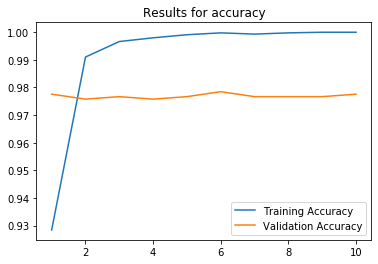

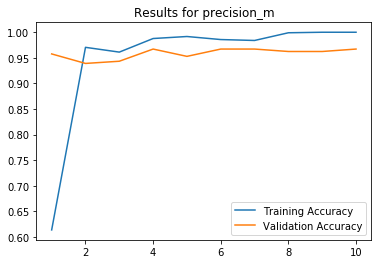

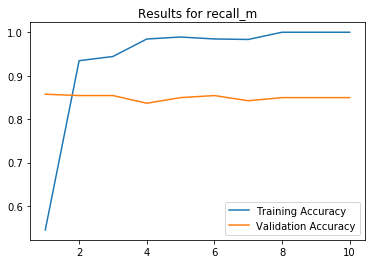

In [31]:
# Plot basic evaluation metrics across epochs
import matplotlib.pyplot as plt
%matplotlib inline

for i in ['accuracy', 'precision_m', 'recall_m']:
    acc = history.history[i]
    val_acc = history.history['val_{}'.format(i)]
    epochs = range(1, len(acc) + 1)

    plt.figure()
    plt.plot(epochs, acc, label='Training Accuracy')
    plt.plot(epochs, val_acc, label='Validation Accuracy')
    plt.title('Results for {}'.format(i))
    plt.legend()
    plt.show()